### Задание

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

2. Оцените ошибку модели из п.2 .

3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

import os

In [3]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [2]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [9]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [10]:
data_d = data['PJME_MW'].resample('d').mean()

In [11]:
data_exp_1 = exponential_smoothing(data_d, 0.08)

In [66]:
df= pd.DataFrame(data_exp_1, index = data_d.index)
df['t1'] = 0
df.iloc[1:,1] = df.iloc[:-1,0].values  # values добавлено, чтобы не срабатывал индекс при присвоении
df['t2'] = 0
df.iloc[2:,2] = df.iloc[:-2,0].values
df['t3'] = 0
df.iloc[3:,3] = df.iloc[:-3,0].values
df['exp_08'] = exponential_smoothing(df[0], 0.08)
df['diff1'] = 0
df['diff1'].iloc[1:] = df.iloc[1:, 0].values - df.iloc[:-1, 0].values
df['diff2'] = 0
df['diff2'].iloc[2:] = df['diff1'].iloc[2:].values - df['diff1'].iloc[1:-1].values

In [67]:
df.head()

,0,t1,t2,t3,exp_08,diff1,diff2
Date,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,0.000000,0.000000
2002-01-02,31335.203333,31080.739130,0.000000,0.000000,31101.096267,254.464203,0.000000
2002-01-03,31589.337067,31335.203333,31080.739130,0.000000,31140.155531,254.133733,-0.330470
2002-01-04,31759.426768,31589.337067,31335.203333,31080.739130,31189.697230,170.089701,-84.044032
2002-01-05,31651.082627,31759.426768,31589.337067,31335.203333,31226.608061,-108.344141,-278.433843


In [163]:
def split_time_ser(ts_df, kf):
    
    beg_interval = int(ts_df.shape[0] * (1-kf))
    return  ts_df.iloc[:beg_interval, :].values, ts_df.iloc[beg_interval:, :].values, ts_df.iloc[:beg_interval, :].index,  ts_df.iloc[beg_interval:, :].index
    

In [164]:
x_train, x_test, index_train, index_test = split_time_ser(df, 0.3)

In [165]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [166]:
y_train, y_test = x_train[:, 0], x_test[:, 0]

In [167]:
h = 1
x_train = x_train[:-h]
y_train = y_train[h:]
index_train = index_train[h:]

x_test = x_test[:-h]
y_test = y_test[h:]
index_test = index_test[h:]

In [168]:
from sklearn.linear_model import LinearRegression as LR

In [169]:
model = LR()
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
print(f'{mean_absolute_percentage_error(y_train, y_train_pred)} %')

0.4062643877473685 %


In [170]:
y_test_pred = model.predict(x_test)
print(f'{mean_absolute_percentage_error(y_test, y_test_pred)} %')

0.4239737074829381 %


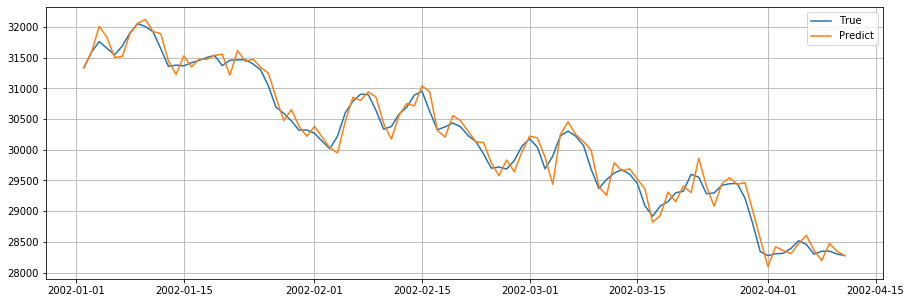

In [171]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.plot(index_train[:100], y_train[:100], label='True')
plt.plot(index_train[:100], y_train_pred[:100], label='Predict')

plt.grid()

plt.legend()
plt.show()

In [172]:
h = 10
x_train = x_train[:-h]
y_train = y_train[h:]
index_train = index_train[h:]

x_test = x_test[:-h]
y_test = y_test[h:]
index_test = index_test[h:]

In [173]:
model = LR()
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
print(f'{mean_absolute_percentage_error(y_train, y_train_pred)} %')

3.072882952124505 %


In [174]:
y_test_pred = model.predict(x_test)
print(f'{mean_absolute_percentage_error(y_test, y_test_pred)} %')

3.653101234755596 %


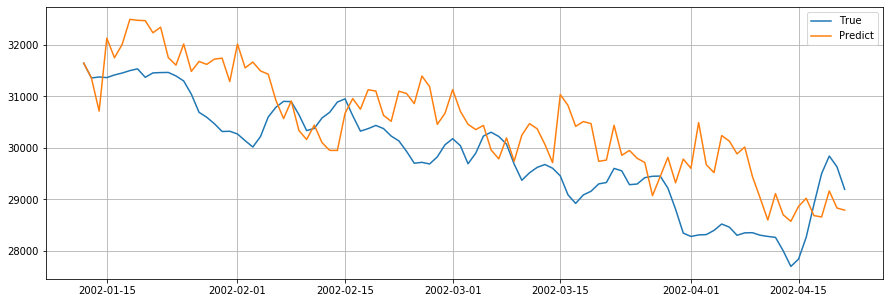

In [175]:
plt.plot(index_train[:100], y_train[:100], label='True')
plt.plot(index_train[:100], y_train_pred[:100], label='Predict')

plt.grid()

plt.legend()
plt.show()

### Вывод однозначный при увеличении горизонта точность упала :)

4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

  а) Изменение температуры за окном :).  - не стационарный, сезон с циклом 1 год, возможны многолетние тренды изменения климата

  б) Количество денег, которые тратят покупатели в интернет магазине. - не стационарный, сезонный с циклом по годовым 
     праздникам, восходящие и нисходящие тренды в рамках жизненного цикла бизнес-проекта

  в) Вес растущего котенка. - не стационарный, тренд возрастающий

  г) Прирост объема деревьев в лесу от времени. Сферический лес в вакууме :), полностью заполнивший ареал - стационарные колебания вокруг среднего, если шаг наблюдений достаточно велик. В реальной природе будут тренды, обусловленные деятельностью человека и климатическими изменениями